In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time


In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_clean_GK.txt"
pcCatalog = "koiCatalogs/dr25_GK_PCs.csv"

period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61

# for quick tests
# nWalkers = 6
# nBurnin = 200
# nMcmc = 1000
# for production runs
nWalkers = 16
nBurnin = 1000
nMcmc = 5000


model = "dualPowerLaw"
whichRadii = "kic"

In [3]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    elif model == "dualPowerLawGap":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 5 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4 \
        and -0.0 <= theta[6] < 0.05:
            return 1.0
    elif model == "dualPowerLawGapFixedSlope":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 0.6 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4:
            return 1.0
    elif model == "dualPowerLawFixedValley":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf


In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"



In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)






In [6]:
# population inference functions

def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15


In [7]:
# population analysis functions

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
#    print("in make_plot, pop_comp:")
#    print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
#    print("pop:")
#    print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$", fontsize = fsize)
    
                
    return gamma_earth, fig


In [8]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    if whichRadii == "corrected Minus 1Sigma":
        return catalog.corrected_prad - catalog.corrected_prad_err1
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string');

In [9]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois


In [10]:
period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape



In [11]:

inputgrid = "../completenessContours/out_sc0_GK_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

# interpolate the numerical grids onto the period_grid, rp_grid space
#print("size probtot = " + str(np.shape(probtot)))
#print("size period_want = " + str(np.shape(period_want)))
#print("size rp_want = " + str(np.shape(rp_want)))

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)



In [12]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)





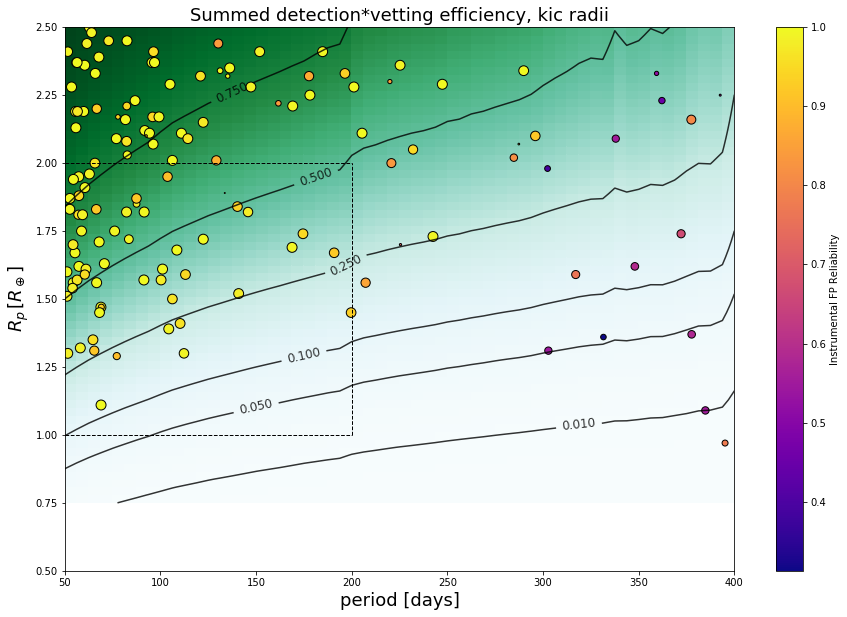

In [13]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]


fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(period_grid, rp_grid, summedProbDet, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Instrumental FP Reliability");

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18);
plt.plot([200, 200], [1, 2], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle='--', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle='--', linewidth=1)
plt.savefig("summedCompleteness.eps",bbox_inches='tight')





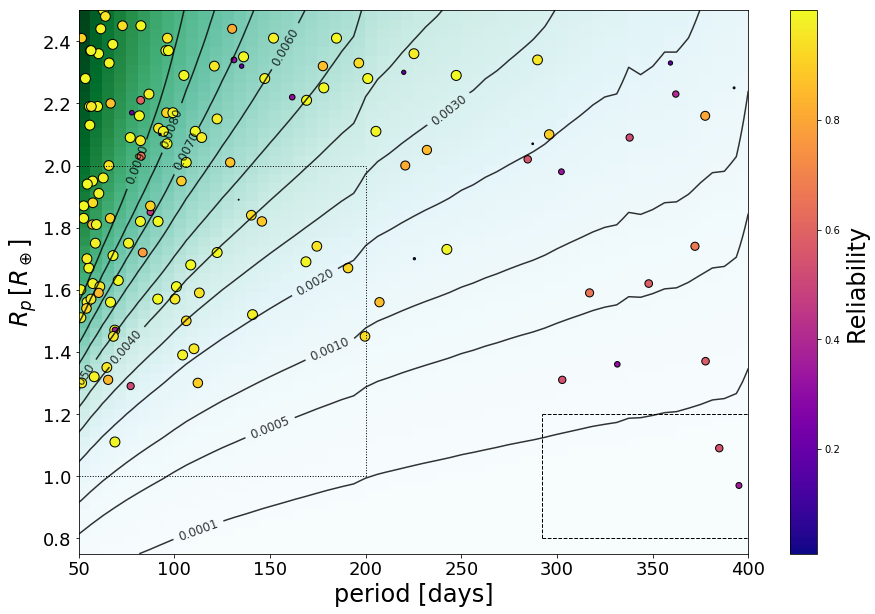

In [14]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = np.arange(1e-3, 1e-2, 1e-3)
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

fig, ax = plt.subplots(figsize=(15,10));

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.75, 2.5)
plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
plt.plot([200, 200], [1, 2], color='k', linestyle=':', linewidth=1)
plt.plot([50, 200], [1, 1], color='k', linestyle=':', linewidth=1)
plt.plot([50, 200], [2, 2], color='k', linestyle=':', linewidth=1)
plt.plot([0.8*365, 0.8*365], [0.8, 1.2], color='k', linestyle='--', linewidth=1)
plt.plot([1.2*365, 1.2*365], [0.8, 1.2], color='k', linestyle='--', linewidth=1)
plt.plot([0.8*365, 1.2*365], [0.8, 0.8], color='k', linestyle='--', linewidth=1)
plt.plot([0.8*365, 1.2*365], [1.2, 1.2], color='k', linestyle='--', linewidth=1)
plt.savefig("summedCompletenessKic.eps",bbox_inches='tight')






In [15]:
1.2*365

438.0

Compute a basic occurrence rate without reliability

[ 0.94039452 -0.48988864 -0.80596327]


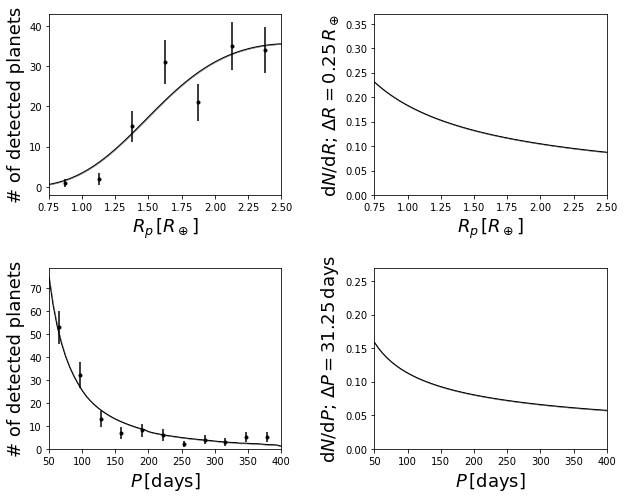

In [16]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(0, 5), (-5, 5), (-5, 5)]
elif model == "dualPowerLawGap":
    bounds = [(0, 5), (-5, 5), (-5, 5), (0, 5), (0.0, 0.3), (0.2, 0.4), (-0.2, 0.2)]
elif model == "dualPowerLawGapFixedSlope":
    bounds = [(0, 5), (-5, 5), (-5, 5), (0, 5), (0.0, 0.3), (0.2, 0.4)]
elif model == "dualPowerLawFixedValley":
    bounds = [(0, 5), (-5, 5), (-5, 5)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)


vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x);



In [17]:
rateModel(365.25, 1.0, period_rng, rp_rng, r.x, model)*365

0.5457666764611208

In [18]:

##################################################################


ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

kois.to_csv("occurenceRatePosteriors/selectedPcs_noreliability.csv")

samples_noreliability = sampler.flatchain   
np.save("occurenceRatePosteriors/occurenceRatePosteriors_noreliability.npy", samples_noreliability)


--- 31.2595949173 seconds ---


0.6006740354430267


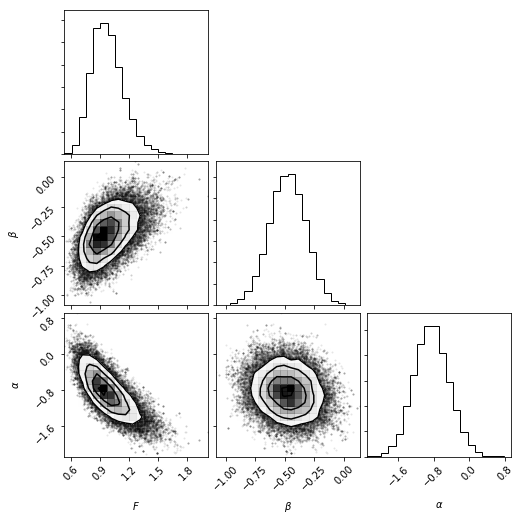

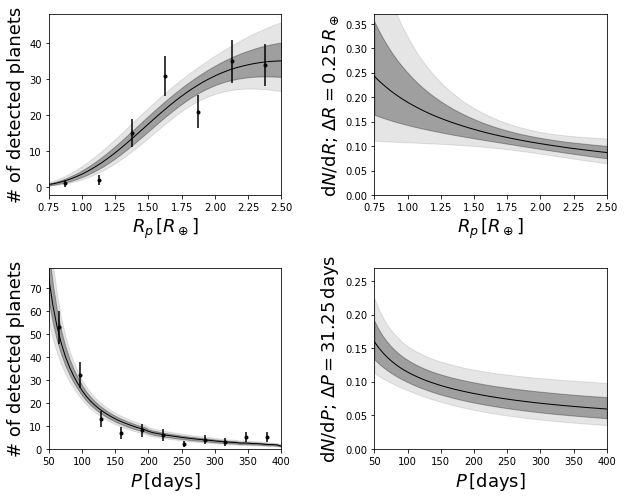

In [19]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model));

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
print(np.mean(gamma_earth_no_reliability))

##################################################################



In [20]:
print("F = " + printMedianAndErrorbars(samples_noreliability[:,0]))
print("radius exp (alpha) = " + printMedianAndErrorbars(samples_noreliability[:,2]))
print("period exp (beta) = " + printMedianAndErrorbars(samples_noreliability[:,1]))





F = 0.963^{+0.178}_{-0.144}
radius exp (alpha) = -0.854^{+0.399}_{-0.382}
period exp (beta) = -0.475^{+0.154}_{-0.155}


Mean Gamma_Earth = 0.566667923029
Gamma at p=365 days, r=1Re without reliability = 0.569^{+0.230}_{-0.166}


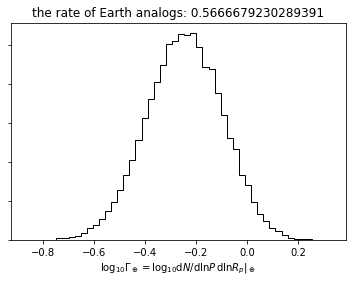

In [21]:

plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_no_reliability))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))
print("Gamma at p=365 days, r=1Re without reliability = " + printMedianAndErrorbars(gamma_earth_no_reliability))




In [22]:
F1Dist_nr = integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model)
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))

F1Dist_nr = integrateRateModel([50.,300.], [0.75, 2.5], samples_noreliability, model)
print("0.75-2.5Re, 50-300 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))



FloatProgress(value=0.0, max=80000.0)

1-2Re, 50-200 Days without reliability = 0.300^{+0.044}_{-0.039}


FloatProgress(value=0.0, max=80000.0)

0.75-2.5Re, 50-300 Days without reliability = 0.759^{+0.129}_{-0.106}


Compute an occurrence rate with reliability

In [23]:
nTrials = 100

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#    koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
    kois = allKois[koiSelect]
    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(getRadii(kois))

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################


    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 400)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 2000)

    samples = sampler.flatchain   
    np.save("occurenceRatePosteriors/occurenceRatePosteriors_" + str(mCount) + ".npy", samples)
    
    f.value += 1



FloatProgress(value=0.0)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [24]:
import gc # for memory management

for mCount in range(nTrials):
    samples = np.load("occurenceRatePosteriors/occurenceRatePosteriors_" + str(mCount) + ".npy");
    
    subsampleFactor = int(np.round(nTrials/10))
    if mCount == 0:
        allSamples = samples[0:-1:subsampleFactor,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:subsampleFactor,:]))
    gc.collect() # force garbage collection before loading another one



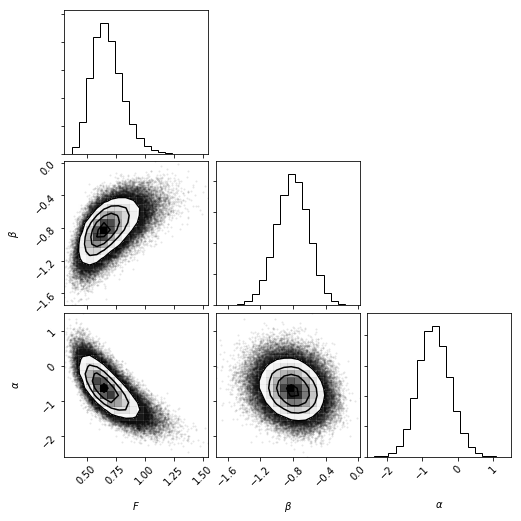

In [25]:
corner.corner(allSamples, labels=getModelLabels(model));
plt.savefig("mcmcSampleDist.eps",bbox_inches='tight')




In [26]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(allSamples[:,i]))


MCMC no reliability $F$=0.963^{+0.178}_{-0.144}
MCMC no reliability $\beta$=-0.475^{+0.154}_{-0.155}
MCMC no reliability $\alpha$=-0.854^{+0.399}_{-0.382}
MCMC with reliability $F$=0.668^{+0.143}_{-0.116}
MCMC with reliability $\beta$=-0.806^{+0.196}_{-0.203}
MCMC with reliability $\alpha$=-0.677^{+0.455}_{-0.432}


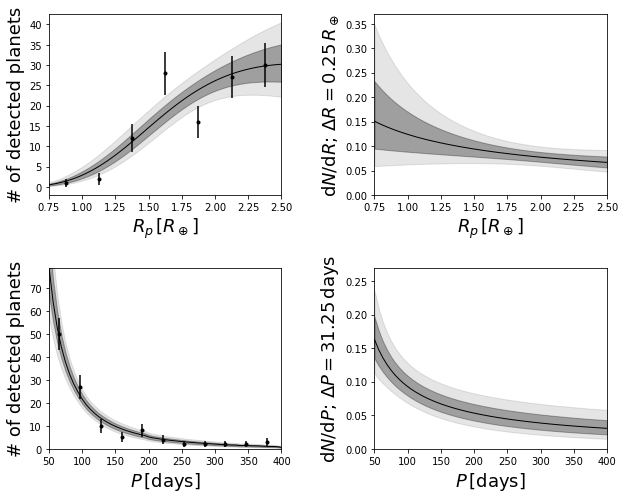

In [27]:
gamma_earth, fig = plot_results(allSamples)
plt.savefig("planetResults.eps",bbox_inches='tight')


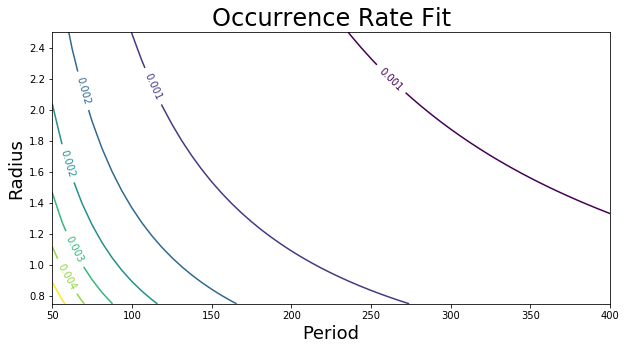

In [28]:
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(allSamples, 0), model)
CS = ax.contour(period_grid, rp_grid, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("Period", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);


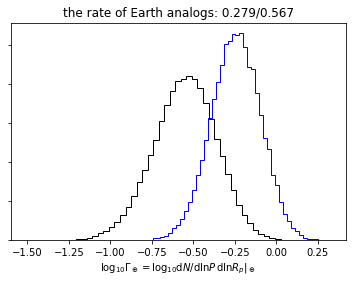

In [29]:
plt.hist(np.log10(gamma_earth), 50, histtype="step", color="k", density=True)
plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(round(10**np.mean(np.log10(gamma_earth)), 3))
    + "/" + str(round(10**np.mean(np.log10(gamma_earth_no_reliability)), 3)))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");




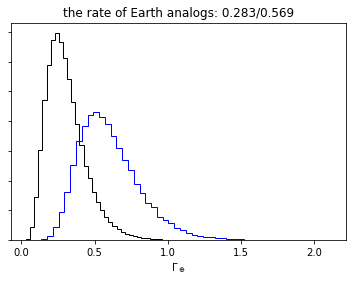

In [30]:
plt.hist(gamma_earth, 50, histtype="step", color="k", density=True)
plt.hist(gamma_earth_no_reliability, 50, histtype="step", color="b", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(round(np.median(gamma_earth), 3))
    + "/" + str(round(np.median(gamma_earth_no_reliability), 3)))
plt.xlabel(r"$\Gamma_\oplus$");




In [31]:
print("Gamma at p=365 days, r=1Re = " + printMedianAndErrorbars(gamma_earth))
print("Gamma at p=365 days, r=1Re without reliability = " + printMedianAndErrorbars(gamma_earth_no_reliability))



Gamma at p=365 days, r=1Re = 0.283^{+0.148}_{-0.102}
Gamma at p=365 days, r=1Re without reliability = 0.569^{+0.230}_{-0.166}


In [32]:
F1Dist = integrateRateModel([50.,200.], [1., 2.], allSamples, model)
F1Dist_nr = integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model)


FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

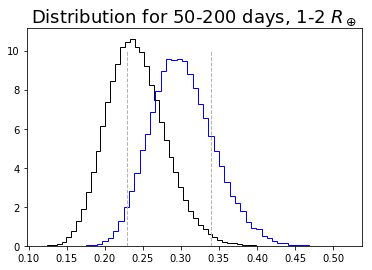

In [33]:
greyLevel = "0.7"
plt.hist(F1Dist, 50, histtype="step", color="k", density=True);
plt.hist(F1Dist_nr, 50, histtype="step", color="b", density=True);
plt.title("Distribution for 50-200 days, 1-2 $R_\oplus$", fontsize=18);
plt.plot([0.34, 0.34], [0, 10], color=greyLevel, linestyle='--', linewidth=1)
plt.plot([0.23, 0.23], [0, 10], color=greyLevel, linestyle='--', linewidth=1)
plt.savefig("f1Dist.eps",bbox_inches='tight')




In [34]:
print("median theta: 1-2Re, 50-200 Days = " + str(integrateRateModel([50.,200.], 
                                               [1., 2.], np.median(allSamples, 0), model)))

print("median theta: 1-2Re, 50-200 Days without reliability = " + str(integrateRateModel([50.,200.], 
                                               [1., 2.], np.median(samples_noreliability, 0), model)))

print("1-2Re, 50-200 Days = " + printMedianAndErrorbars(F1Dist))
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))



median theta: 1-2Re, 50-200 Days = 0.24030242789824202
median theta: 1-2Re, 50-200 Days without reliability = 0.3008581202811736
1-2Re, 50-200 Days = 0.239^{+0.040}_{-0.036}
1-2Re, 50-200 Days without reliability = 0.300^{+0.044}_{-0.039}


In [35]:
zetaDist = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], allSamples, model)
zetaDist_nr = integrateRateModel([.8*365.25,1.2*365.25], 
                              [0.8,1.2], samples_noreliability, model)


FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

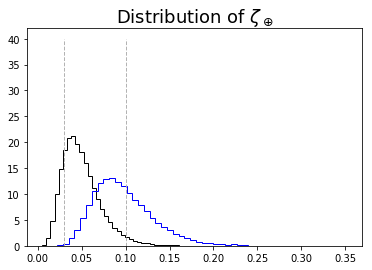

In [36]:
plt.hist(zetaDist, 50, histtype="step", color="k", density=True);
plt.hist(zetaDist_nr, 50, histtype="step", color="b", density=True);
plt.title("Distribution of $\zeta_\oplus$", fontsize=18);
plt.plot([0.1, 0.1], [0, 40], color=greyLevel, linestyle='--', linewidth=1)
plt.plot([0.03, 0.03], [0, 40], color=greyLevel, linestyle='--', linewidth=1)

plt.savefig("zetaEarthDist.eps",bbox_inches='tight')



In [37]:
print("median theta: zeta-Earth = " + str(integrateRateModel([.8*365.25,1.2*365.25], 
                                               [0.8,1.2], np.median(allSamples, 0), model)))

print("median theta: zeta-Earth without reliability = " + str(integrateRateModel([.8*365.25,1.2*365.25], 
                                               [0.8,1.2], np.median(samples_noreliability, 0), model)))

print("zeta-Earth = " + printMedianAndErrorbars(zetaDist))
print("zeta-Earth without reliability = " + printMedianAndErrorbars(zetaDist_nr))





median theta: zeta-Earth = 0.04658525687852911
median theta: zeta-Earth without reliability = 0.09336902643278779
zeta-Earth = 0.046^{+0.024}_{-0.017}
zeta-Earth without reliability = 0.093^{+0.038}_{-0.027}


In [38]:
sag13HZDist = integrateRateModel([237,860], [0.5,1.5], allSamples, model)
plt.hist(sag13HZDist, 50, histtype="step", color="k", density=True);
sag13HZDist_nr = integrateRateModel([237,860], [0.5,1.5], samples_noreliability, model)
plt.hist(sag13HZDist_nr, 50, histtype="step", color="b", density=True);

FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

In [39]:
print("median theta: SAG13 HZ = " + str(integrateRateModel([237,860], 
                                               [0.5,1.5], np.median(allSamples, 0), model)))

print("median theta: SAG13 HZ without reliability = " + str(integrateRateModel([237,860], 
                                               [0.5,1.5], np.median(samples_noreliability, 0), model)))

print("SAG13 HZ = " + printMedianAndErrorbars(sag13HZDist))
print("SAG13 HZ without reliability = " + printMedianAndErrorbars(sag13HZDist_nr))



FloatProgress(value=0.0, max=80000.0)

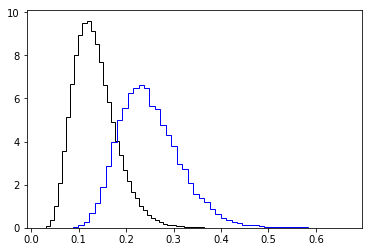

In [40]:
hsuFordDist = integrateRateModel([237,500], [1.0,1.75], allSamples, model)
plt.hist(hsuFordDist, 50, histtype="step", color="k", density=True);
hsuFordDist_nr = integrateRateModel([237,500], [1.0,1.75], samples_noreliability, model)
plt.hist(hsuFordDist_nr, 50, histtype="step", color="b", density=True);

In [41]:
print("median theta: Hsu and Ford HZ = " + str(integrateRateModel([237,500], [1.0,1.75], np.median(allSamples, 0), model)))

print("median theta: Hsu and Ford HZ without reliability = " + str(integrateRateModel([237,500], [1.0,1.75], np.median(samples_noreliability, 0), model)))

print("Hsu and Ford HZ = " + printMedianAndErrorbars(hsuFordDist))
print("Hsu and Ford HZ without reliability = " + printMedianAndErrorbars(hsuFordDist_nr))




median theta: Hsu and Ford HZ = 0.12962887828444683
median theta: Hsu and Ford HZ without reliability = 0.24401591812805343
Hsu and Ford HZ = 0.129^{+0.050}_{-0.038}
Hsu and Ford HZ without reliability = 0.242^{+0.070}_{-0.055}


FloatProgress(value=0.0, max=120000.0)

FloatProgress(value=0.0, max=80000.0)

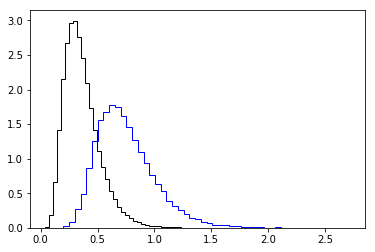

In [42]:
habDist = integrateRateModel([0.61*365,2.216*365], [0.72,1.7], allSamples, model)
plt.hist(habDist, 50, histtype="step", color="k", density=True);
habDist_nr = integrateRateModel([0.61*365,2.216*365], [0.72,1.7], samples_noreliability, model)
plt.hist(habDist_nr, 50, histtype="step", color="b", density=True);

In [43]:
print("median theta: Zink HZ = " + str(integrateRateModel([0.61*365,2.216*365], [0.72,1.7], np.median(allSamples, 0), model)))

print("median theta: Zink HZ without reliability = " + str(integrateRateModel([0.61*365,2.216*365], [0.72,1.7], np.median(samples_noreliability, 0), model)))

print("Zink HZ = " + printMedianAndErrorbars(habDist))
print("Zink HZ without reliability = " + printMedianAndErrorbars(habDist_nr))



median theta: Zink HZ = 0.3392564995927858
median theta: Zink HZ without reliability = 0.7131286104137209
Zink HZ = 0.337^{+0.172}_{-0.118}
Zink HZ without reliability = 0.709^{+0.281}_{-0.201}


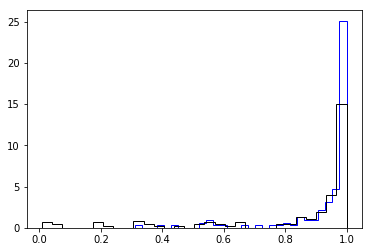

In [44]:
plt.hist(allKois.reliability, 30, histtype="step", color="b", density=True);
plt.hist(allKois.totalReliability, 30, histtype="step", color="k", density=True);

In [45]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [46]:
%%bash -s  "$model"
jupyter nbconvert --to html computeOccurrence.ipynb
mv computeOccurrence.html htmlArchive/computeOccurrence_$1.html

[NbConvertApp] Converting notebook computeOccurrence.ipynb to html
[NbConvertApp] Writing 1362796 bytes to computeOccurrence.html
